# 1. Setting Up

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

np.random.seed(416)

In [24]:
from sklearn.metrics import confusion_matrix

def visualize_confusion_matrix(test, pred, score):
    cm = confusion_matrix(test, pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15)

# 2. Inspecting Data

In [25]:
bank_fraud = pd.read_csv('bank_fraud.csv')
bank_fraud = bank_fraud.drop(columns = ['Unnamed: 0'])
print(len(bank_fraud))
bank_fraud.head()

20000


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


# 3. Pre-processing

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:

+1 as legitimate,
-1 as fraud.

In [26]:
bank_fraud['not_fraud'] = bank_fraud['fraud_bool'].apply(lambda x : +1 if x==0 else -1)

# Drop the old bad_loans column
bank_fraud = bank_fraud.drop(columns='fraud_bool')

In [27]:
only_legit = bank_fraud[bank_fraud['not_fraud'] == 1]
only_fraud = bank_fraud[bank_fraud['not_fraud'] == -1]

print(f'Number of legit applications: {len(only_legit)} ({len(only_legit) * 100.0 / len(bank_fraud):.2f}%)')
print(f'Number of fraud applications: {len(only_fraud)} ({len(only_fraud) * 100.0 / len(bank_fraud):.2f}%)')

Number of legit applications: 18572 (92.86%)
Number of fraud applications: 1428 (7.14%)


## Feature Selection

In [28]:
bank_fraud.columns

Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'zip_count_4w', 'velocity_6h',
       'velocity_24h', 'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month',
       'not_fraud'],
      dtype='object')

In [29]:
features = [
    'income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'zip_count_4w', 'velocity_6h',
       'velocity_24h', 'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month' 
]

target = 'not_fraud'   

# Extract the feature columns and target column
bank_fraud = bank_fraud[features + [target]]
bank_fraud.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,...,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,not_fraud
0,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,10650.765523,...,500.0,0,INTERNET,3.888115,windows,0,1,0,7,-1
1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,534.047319,...,1500.0,0,INTERNET,31.798819,windows,0,1,0,7,-1
2,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,4048.534263,...,200.0,0,INTERNET,4.728705,other,0,1,0,7,-1
3,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,3457.064063,...,200.0,0,INTERNET,2.047904,linux,0,1,0,7,-1
4,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,5020.341679,...,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7,-1


With how `sklearn` implemented its `DecisionTreeClassifier`, it is only able to handle numerical features; the technical reason being it only allows binary splits and assumes (like other `sklearn` models), that the data is only numerical. This means we need to translate the categorical features into numeric ones. 

The easiest way to do this is a **one-hot encoding** of each categorical feature. A one hot encoding of a feature creates new, derived, features that take on the value 0 or 1 (one new feature for each possible value of the original). This allows us to turn a categorical feature into a series of binary (0 or 1) numerical features.

In [30]:
bank_fraud = pd.get_dummies(bank_fraud)
features = list(bank_fraud.columns)
features.remove('not_fraud')
features

['income',
 'name_email_similarity',
 'prev_address_months_count',
 'current_address_months_count',
 'customer_age',
 'days_since_request',
 'intended_balcon_amount',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'credit_risk_score',
 'email_is_free',
 'phone_home_valid',
 'phone_mobile_valid',
 'bank_months_count',
 'has_other_cards',
 'proposed_credit_limit',
 'foreign_request',
 'session_length_in_minutes',
 'keep_alive_session',
 'device_distinct_emails_8w',
 'device_fraud_count',
 'month',
 'payment_type_AA',
 'payment_type_AB',
 'payment_type_AC',
 'payment_type_AD',
 'payment_type_AE',
 'employment_status_CA',
 'employment_status_CB',
 'employment_status_CC',
 'employment_status_CD',
 'employment_status_CE',
 'employment_status_CF',
 'employment_status_CG',
 'housing_status_BA',
 'housing_status_BB',
 'housing_status_BC',
 'housing_status_BD',
 'housing_status_BE',
 'housing_status_BF',
 'source_I

In [31]:
train_val, test_data = train_test_split(bank_fraud, test_size = 0.1)
train_data, validation_data = train_test_split(train_val, test_size=0.2)

# 5. Decision Tree Classifiers

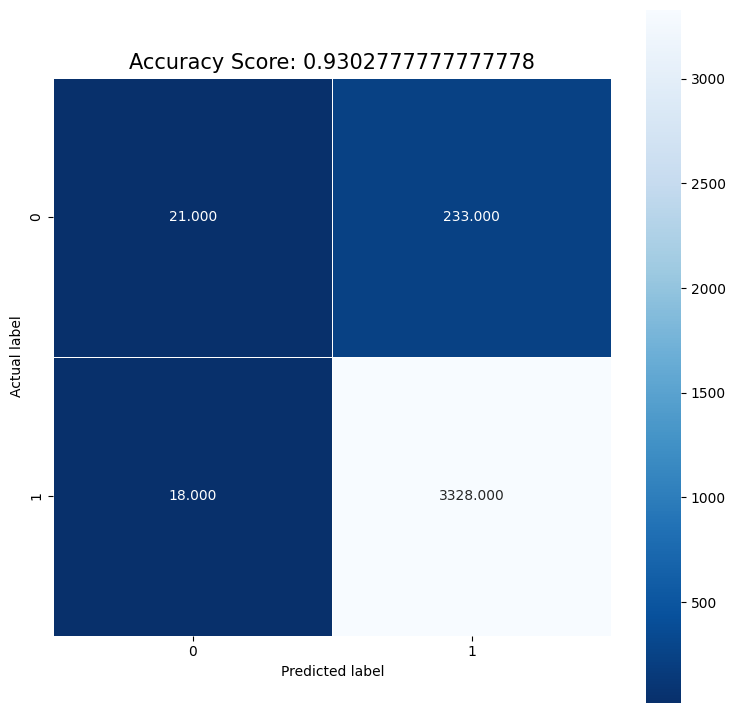

In [32]:
dt = DecisionTreeClassifier(max_depth=4, random_state=7)

#Fit the training data to decision tree
dt.fit(train_data[features], train_data[target])

# Let's see and visualize how our predictions look
dt_y_pred = dt.predict(validation_data[features])
dt_score = dt.score(validation_data[features], validation_data[target])
visualize_confusion_matrix(validation_data[target], dt_y_pred, dt_score)

Now, let's visualize the tree we are making. Note that if you alter the `max_depth` in code below, you will need to save the image to view it in full.

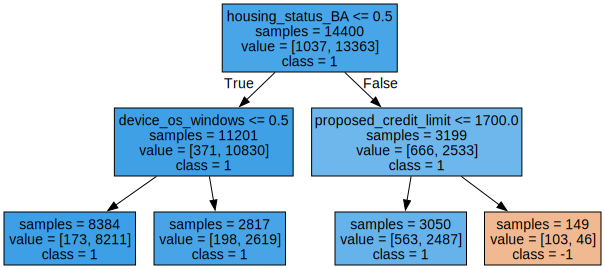

In [33]:
import graphviz
from sklearn import tree

def draw_tree(tree_model, features):
    """
    visualizes a Decision Tree
    """
    tree_data = tree.export_graphviz(tree_model, 
                                    impurity=False, 
                                    feature_names=features,
                                    class_names=tree_model.classes_.astype(str),
                                    filled=True,
                                    out_file=None)
    graph = graphviz.Source(tree_data) 
    display(graph)
    
small_tree_model = DecisionTreeClassifier(max_depth=2, random_state=0)
small_tree_model.fit(train_data[features], train_data[target])
draw_tree(small_tree_model, features)

# 6. Implementing a Majority Class Classifier

In [ ]:
# implement a class
class MajorityClassClassifier:

    def __init__(self):
        # input: none
        # output: none

        self._label = None

    def fit(self, x, y):
        # input: target and label data
        # output: none

        vals, counts = np.unique(y, return_counts=True)
        index = np.argmax(counts)
        self._label = vals[index]

    def predict(self, x):
        # input: target data
        # output: predicted results

        if self._label is None:
            return None
        else:
            return np.array([self._label for i in x])

    def score(self, x, y):
        # input: target and label data
        # output: accuracy score of our classifier
        
        majority = y[y == self._label]
        return len(majority) / len(y)

# 6. Using our implemented class

0.9315


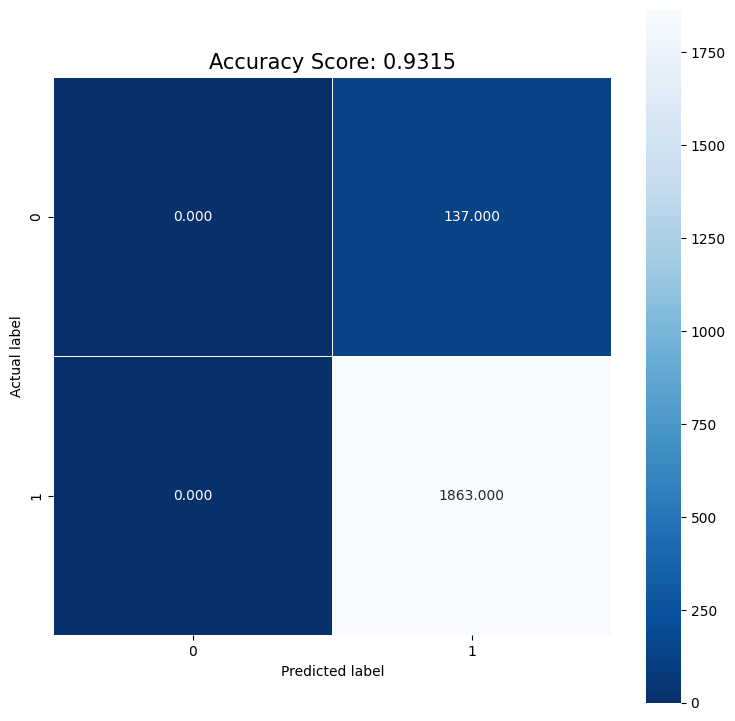

In [ ]:
mc = MajorityClassClassifier()

mc.fit(train_data[features], train_data[target])

mc_score = mc.score(test_data[features], test_data[target])
print(mc_score)

mc_y_pred = mc.predict(test_data[target])

visualize_confusion_matrix(test_data[target], mc_y_pred, mc_score)